# Creating custom Pyfunc models

MLflow’s persistence modules provide convenience functions for creating models with the pyfunc flavor in a variety of machine learning frameworks (scikit-learn, Keras, Pytorch, and more); however, they do not cover every use case. For example, you may want to create an MLflow model with the pyfunc flavor using a framework that MLflow does not natively support. Alternatively, you may want to build an MLflow model that executes custom logic when evaluating queries, such as preprocessing and postprocessing routines. Therefore, mlflow.pyfunc provides utilities for creating pyfunc models from arbitrary code and model data.

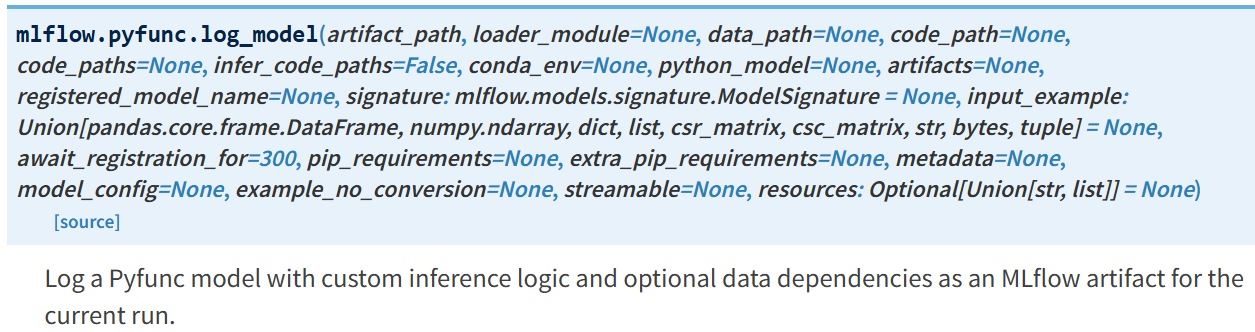
## Function-based Model & Class-based Model

### Function-based Model

If you’re looking to serialize a simple python function without additional dependent methods, you can simply log a predict method via the keyword argument python_model.




In [ ]:
import mlflow
from mlflow_for_ml_dev.src.utils.folder_operations import get_project_root

# set mlflow tracking uri
mlflow.set_tracking_uri(uri=(get_project_root() / 'mlruns').as_uri())

In [ ]:
import pandas as pd

If `python_model` is a callable object, at least one of `input_example`, `pip_requirements`, or `extra_pip_requirements` must be specified.

In [ ]:
# Define a simple function to log
def predict(model_input):
    """
    Predicts the input multiplied by 2

    :param model_input: The input to the model
    :return: The input multiplied by 2
    """
    return model_input.apply(lambda x: x * 2)


# Save the function as a model
with mlflow.start_run(run_name="function_model"):
    mlflow.pyfunc.log_model("model", python_model=predict, pip_requirements=["pandas"])
    run_id = mlflow.active_run().info.run_id

# Load the model from the tracking server and perform inference
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")
x_new = pd.Series([1,2,3,4,5])

prediction = model.predict(x_new)
print(prediction)

### Class-based Model

If you’re looking to serialize a more complex object, for instance a class that handles preprocessing, complex prediction logic, or custom serialization, you should subclass the PythonModel class.

--------
```python
import mlflow
import pandas as pd

class MyModel(mlflow.pyfunc.PythonModel):
    def predict(self, context, model_input, params=None):
        return [x*2 for x in model_input]

# Save the function as a model
with mlflow.start_run():
    mlflow.pyfunc.log_model("model", python_model=MyModel(), pip_requirements=["pandas"])
    run_id = mlflow.active_run().info.run_id

# Load the model from the tracking server and perform inference
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")
x_new = pd.Series([1, 2, 3])

print(f"Prediction:
    {model.predict(x_new)}")
```
--------

Basic Guidelines for a PythonModel

The guidelines for this approach are as follows:

* Your class must be a subclass of mlflow.pyfunc.PythonModel

* Your class must implement a predict method

* The predict method must adhere to the requirements of the Inference API.

* The predict method must have reference to context as the first named argument

* If you wish to provide parameters with your model, these must be defined as part of the model signature. The signature must be saved along with the model.

* If you intend to have additional functionality execute when loading the model (such as loading additional dependent files), you may decide to define the load_context method in your class.



In [ ]:
class CustomModel(mlflow.pyfunc.PythonModel):
    
    def predict(self, context, model_input):
        self._preprocess(model_input)
        return model_input.apply(lambda x: x * 2)
    
    def _preprocess(self, model_input):
        print("processing input....") 
        print("Input Length: ", len(model_input))

In [ ]:
with mlflow.start_run(run_name="class_model") as run:
    print(run.info.run_id)
    mlflow.pyfunc.log_model("model", python_model=CustomModel(), pip_requirements=["pandas"])
    

In [ ]:
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run.info.run_id}/model")
prediction = loaded_model.predict(x_new)
print(prediction)

# Obtaining the original Class

In [ ]:
class CustomModel(mlflow.pyfunc.PythonModel):
    def __init__(self):
        pass

    def predict(self, context, model_input):
        self._preprocess(model_input)
        return model_input.apply(lambda x: x * 2)
    
    def _preprocess(self, model_input):
        print("processing input....") 
        print("Input Length: ", len(model_input))

    def additional_method(self):
        print("Running an additional method")

In [ ]:
with mlflow.start_run(run_name="class_model_with_additional_methods") as run:
    print(run.info.run_id)
    mlflow.pyfunc.log_model("model", python_model=CustomModel(), pip_requirements=["pandas"])
    

In [ ]:
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run.info.run_id}/model")
prediction = loaded_model.predict(x_new)
print(prediction)

In [ ]:
type(loaded_model)

In [ ]:
# I can use the method "unwrap_python_model" to get the original class
original_class = loaded_model.unwrap_python_model()
original_class.additional_method()

In [ ]:
original_class._preprocess(x_new)

In [ ]:
type(original_class)

## Custom Models with Signature

In [ ]:
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema 
from mlflow.types.schema import ColSpec
from mlflow.types.schema import ParamSchema
from mlflow.types.schema import ParamSpec

In [ ]:
input_schema = Schema([
    ColSpec(type="integer", name="input", required=True),
])

output_schema = Schema([
    ColSpec(type="long", name="output", required=True),
])

param = ParamSchema(params = [
    ParamSpec(name="factor", dtype="integer", default=1)
])

model_signature = ModelSignature(inputs=input_schema, outputs=output_schema, params=param)

model_signature.to_dict()

In [ ]:
class CustomModel(mlflow.pyfunc.PythonModel):
    def __init__(self):
        pass

    def predict(self, context, model_input, params=None):
        self._preprocess(model_input)
        self.__preprocess_params(params)
        factor = params.get("factor", 1)
        return model_input.apply(lambda x: x * factor)
    
    def __preprocess_params(self, params):
        if params:
            print("Processing params....")
            print(params)
        else:
            print("No params provided")
    
    def _preprocess(self, model_input):
        print("processing input....") 
        print("Input Length: ", len(model_input))

    def additional_method(self):
        print("Running an additional method")



Saving the model with parameters

In [ ]:
with mlflow.start_run(run_name="class_model_with_parameters") as run:
    print(run.info.run_id)
    mlflow.pyfunc.log_model("model", python_model=CustomModel(), signature=model_signature)

In [ ]:
run_id = run.info.run_id
model_uri = f"runs:/{run_id}/model"
x_new = pd.DataFrame({"input": [1,2,3,4,5]}, dtype="int32")
loaded_model = mlflow.pyfunc.load_model(model_uri)

In [ ]:
# inference with default parameters
prediction = loaded_model.predict(x_new)
print(prediction)

In [ ]:
# inference with custom parameters
prediction = loaded_model.predict(x_new, {"factor": 10})
print(prediction)